<a href="https://colab.research.google.com/github/imranmurtaza110/RL_Lunar_lander/blob/main/lunar_lander_double_q_learning_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
!pip install gymnasium
!pip install swig
!apt-get install -y python-box2d
!pip install gymnasium[box2d]
!pip install pyvirtualdisplay
!apt-get update
!apt-get install -y xvfb
!apt-get update
!apt-get install -y xvfb python-opengl ffmpeg swig

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-box2d
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 229 kB in 2s (144 kB/s)
Reading package lists... Done
Reading package lists... Done
Building dependen

In [28]:
from pyvirtualdisplay import Display
from IPython.display import display as ipy_display, HTML
from base64 import b64encode
display = Display(visible=0, size=(1400, 900))
display.start()

from gymnasium.wrappers import RecordVideo

In [29]:
import gymnasium as gym

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim

# Deep learning model with fully connected layers
class DeepQLearning(nn.Module):
  def __init__(self, fc_1, fc_2, fc_3):
      super().__init__()
      self.model = nn.Sequential(
            nn.Linear(8, fc_1),
            nn.ReLU(),
            nn.Linear(fc_1, fc_2),
            nn.ReLU(),
            nn.Linear(fc_2, fc_3),
            nn.ReLU(),
            nn.Linear(fc_3, 4)
        )

  def forward(self, x):
    return self.model(x)


In [31]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [32]:
# Loss Function class with adam optimizer
class LossFunction:
  def __init__(self, model, lr):
        self.model = model
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

  def step(self, loss):
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()


In [33]:
import numpy as np
import random
from collections import deque
from math import sqrt, log

"""
  Epsilon-greedy strategy is used for action selection in Agent class.
  Manages an experience replay buffer and a neural network model for decision-making.
  Epsilon, representing the exploration rate, decays over time but is bounded by a minimum threshold.
  Employs the Bellman equation for updating the model based on stored experiences.
"""
class Agent:
  def __init__(self, action_space, observation_space, epsilon, min_epsilon, epsilon_decay, lr, model, fc_1, fc_2, fc_3):
    self.action_space = action_space
    self.observation_space = observation_space
    self.epsilon = epsilon
    self.epsilon_decay = epsilon_decay
    self.experience_buffer = deque(maxlen=5000000)
    self.model = model
    self.target_model = DeepQLearning(fc_1, fc_2, fc_3)
    self.target_model.load_state_dict(model.state_dict())
    self.min_epsilon = min_epsilon
    self.optimizer = LossFunction(self.model, lr=lr)

  def update_epsilon(self):
        if self.epsilon not in [0.01]:
          if self.epsilon > self.min_epsilon:
            self.epsilon -= self.epsilon_decay
          elif self.epsilon < 0:
            self.epsilon = self.min_epsilon
        return self.epsilon

  def select_action(self, state):
    if np.random.random() < self.epsilon:
        return np.random.randint(self.action_space)
    else:
        if not state[1]:
          state_tensor = torch.FloatTensor(state[0][0:8]).unsqueeze(0)
        else:
          state_tensor = torch.FloatTensor(state).unsqueeze(0)

        act_values = self.model(state_tensor)
        return torch.argmax(act_values).item()


  def experience_replay_buffer(self, state, action, reward, next_state, done):
      self.experience_buffer.append((state, action, reward, next_state, done))


  def play(self, batch_size, gamma):
      if len(self.experience_buffer) < batch_size:
          return 0
      batch = random.sample(self.experience_buffer, batch_size)

      states = []
      actions = []
      rewards = []
      next_states = []
      dones = []

      for (state, action, reward, next_state, done) in batch:
          states.append(state)
          actions.append(action)
          rewards.append(reward)
          next_states.append(next_state)
          dones.append(done)

      states_flat = []
      for entry in states:
          if isinstance(entry, tuple) and len(entry) == 2:
              states_flat.append(entry[0])
          else:
              states_flat.append(entry)

      states_tensor = torch.tensor(states_flat, dtype=torch.float32)

      states = states_tensor
      actions = torch.tensor(actions, dtype=torch.long)
      rewards = torch.tensor(rewards, dtype=torch.float32)
      next_states = torch.tensor(next_states, dtype=torch.float32)
      dones = torch.tensor(dones, dtype=torch.float32)

      current_q_values = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
      next_actions = self.model(next_states).argmax(1)
      next_q_values = self.target_model(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
      expected_q_values = self.calculate_q_values(rewards, gamma, next_q_values, dones)


      loss = nn.MSELoss()(current_q_values, expected_q_values)

      self.optimizer.step(loss)

      return loss.item()

  def update_target_network(self):
      self.target_model.load_state_dict(self.model.state_dict())

   # bellman equation
  def calculate_q_values(self, rewards, gamma, next_q_values, is_done):
    target_q_values = []
    for i in range(len(rewards)):
        if is_done[i]:
            target_q = rewards[i]
        else:
            target_q = rewards[i] + gamma * torch.max(next_q_values[i]) * (1 - is_done[i])

        target_q_values.append(target_q)
    target_q_values = torch.tensor(target_q_values)
    return target_q_values

In [34]:
import matplotlib.pyplot as plt

# Different graphs are used for data visualization

def plot_steps_per_episode(episodes, steps_per_episode):
  x_axis = episodes
  y_axis = steps_per_episode
  plt.plot(x_axis, y_axis)
  plt.xlabel('Episodes')
  plt.ylabel('Steps')
  plt.title('Steps / Episodes')
  plt.show()

def plot_rewards_per_episode(episodes, rewards):
  x_axis = episodes
  y_axis = rewards

  plt.plot(x_axis, y_axis, '-o')
  plt.xlabel('Episode')
  plt.ylabel('Reward')
  plt.title('Reward / Episode')
  plt.show()


def plot_cumulative_rewards(episodes, episode_rewards):
    avg_rewards = [sum(episode_rewards[:i+1]) / len(episode_rewards[:i+1]) for i in range(len(episode_rewards))]
    plt.plot(episodes, avg_rewards)
    plt.xlabel('Episodes')
    plt.ylabel('Commulative Reward')
    plt.title('Commulative Reward / Episodes')
    plt.show()


def plot_average_reward_per_hundred_episodes(episodes, episode_rewards):
    num_chunks = len(episode_rewards) // 100

    average_rewards = []
    episode_indices = []

    for i in range(num_chunks):
        start_index = i * 100
        end_index = start_index + 100
        chunk = episode_rewards[start_index:end_index]
        average_reward = sum(chunk) / 100

        average_rewards.append(average_reward)
        episode_indices.append(episodes[end_index - 1])

    plt.plot(episode_indices, average_rewards)
    plt.xlabel('Episodes')
    plt.ylabel('Average Reward')
    plt.title('Average Reward Per 100 Episodes')
    plt.show()



def plot_loss_function(episodes, loss):
    batch_size = 50
    num_chunks = len(loss) // batch_size

    average_losses = []
    episode_indices = []

    for i in range(num_chunks):
        start_index = i * batch_size
        end_index = start_index + batch_size
        chunk = loss[start_index:end_index]
        average_loss = sum(chunk) / batch_size

        average_losses.append(average_loss)
        episode_indices.append(episodes[end_index - 1])  # End of each batch

    plt.plot(episode_indices, average_losses)
    plt.xlabel('Episodes')
    plt.ylabel('Average Loss')
    plt.title('Average Loss Per 50 Episodes')
    plt.show()

In [37]:
# Create the environment
import time


def testbed(epi, steps_taken, epsilon, min_epsilon, epsilon_decay, lr, fc_1, fc_2, fc_3, batch_size, gamma):

  env = gym.make(
      "LunarLander-v2",
      render_mode="rgb_array",

  )

  # Fixing seeds
  gym.envs.register(
      id='LunarLander-seed-v2',
      entry_point='gym.envs.box2d:LunarLander',
      kwargs={'seed': 72}  # Pass the seed as a keyword argument
  )

  video_folder = "/content/videos"

  folder = video_folder + f"/episode_{2}"
  # # wrap the env in the record video
  env = gym.wrappers.RecordVideo(
      env,
      "folder",  # Replace with your desired folder path
      name_prefix="video-",
      episode_trigger=lambda x: x % 50 == 0
  )

  observation_shape = env.observation_space.shape

  num_actions = env.action_space.n
  model = DeepQLearning(fc_1, fc_2, fc_3)

  # Initialize the agent
  agent = Agent(num_actions, observation_shape, epsilon, min_epsilon, epsilon_decay, lr, model, fc_1, fc_2, fc_3)



  # Main loop
  episodes = []
  steps_per_episode = []
  episode_rewards = []
  time_limit_seconds = 30
  total_loss = []
  # env reset for a fresh start
  observation, info = env.reset()
  env.start_video_recorder()
  observation = env.reset()

  for i in range(epi):

    state = env.reset()
    total_losses = 0
    total_reward = 0
    start_time = time.time()
    for j in range(steps_taken):  # Maximum episode length
        action = agent.select_action(state)
        next_state, reward, done, _, _ = env.step(action)
        agent.experience_replay_buffer(state, action, reward, next_state, done)
        state = next_state
        loss = agent.play(batch_size=batch_size, gamma=gamma)
        total_losses += loss
        total_reward += reward

        if i % 4 == 0:
          agent.update_target_network()

        elapsed_time = time.time() - start_time

        if done or elapsed_time >= time_limit_seconds or j == (steps_taken-1):
            done = True
            episodes.append(i+1)
            steps_per_episode.append(j)
            episode_rewards.append(total_reward)
            total_loss.append(total_losses)
            if i % 50 == 0:
              print('total episodes: ' + str(i))
              print('total time: ' + str(elapsed_time))
              print('total steps to complete the episode: ' + str(j))
              print('reward for current state: ' + str(reward))
              print('reward for this episode: ' + str(total_reward))
              print('\n')
            break




    #  printing graph after every 100 iterations to visualize it
    if (i+1) % 100 == 0:
      plot_steps_per_episode(episodes, steps_per_episode)
      plot_rewards_per_episode(episodes, episode_rewards)
      plot_cumulative_rewards(episodes, episode_rewards)
      plot_average_reward_per_hundred_episodes(episodes, episode_rewards)
      plot_loss_function(episodes, total_loss)

    env.render()
    epsilon_value = agent.update_epsilon()
    env.close_video_recorder()
    env.close()

  return episodes, steps_per_episode, episode_rewards, total_loss




/usr/local/lib/python3.10/dist-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment LunarLander-seed-v2 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/folder folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /content/folder/video--episode-0.mp4.
Moviepy - Writing video /content/folder/video--episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/folder/video--episode-0.mp4
Moviepy - Building video /content/folder/video--episode-0.mp4.
Moviepy - Writing video /content/folder/video--episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/folder/video--episode-0.mp4
total episodes: 0
total time: 2.2079310417175293
total steps to complete the episode: 90
reward for current state: -100
reward for this episode: -94.9559715939788


Moviepy - Building video /content/folder/video--episode-50.mp4.
Moviepy - Writing video /content/folder/video--episode-50.mp4



Moviepy - Done !
Moviepy - video ready /content/folder/video--episode-50.mp4


Moviepy - Building video /content/folder/video--episode-50.mp4.
Moviepy - Writing video /content/folder/video--episode-50.mp4



Moviepy - Done !
Moviepy - video ready /content/folder/video--episode-50.mp4
total episodes: 50
total time: 2.082968235015869
total steps to complete the episode: 103
reward for current state: -100
reward for this episode: -49.72537549477187




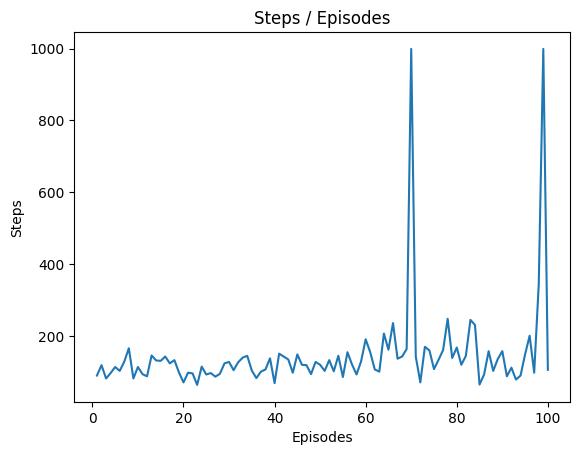

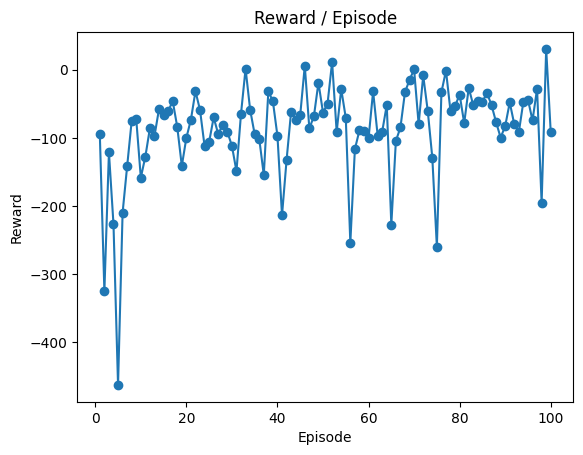

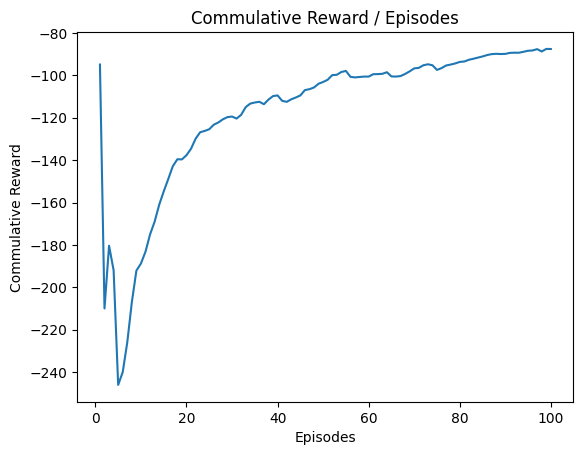

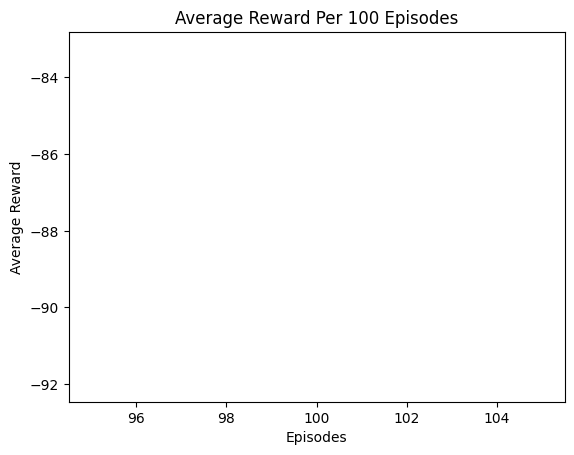

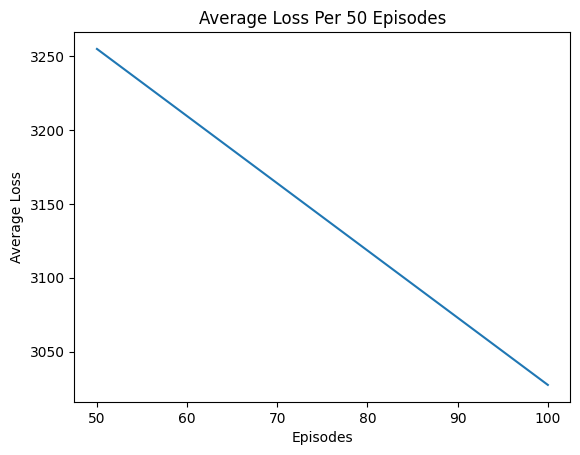

Moviepy - Building video /content/folder/video--episode-100.mp4.
Moviepy - Writing video /content/folder/video--episode-100.mp4



Moviepy - Done !
Moviepy - video ready /content/folder/video--episode-100.mp4


Moviepy - Building video /content/folder/video--episode-100.mp4.
Moviepy - Writing video /content/folder/video--episode-100.mp4



Moviepy - Done !
Moviepy - video ready /content/folder/video--episode-100.mp4
total episodes: 100
total time: 3.14652943611145
total steps to complete the episode: 125
reward for current state: -100
reward for this episode: -29.866725064138365


Moviepy - Building video /content/folder/video--episode-150.mp4.
Moviepy - Writing video /content/folder/video--episode-150.mp4



Moviepy - Done !
Moviepy - video ready /content/folder/video--episode-150.mp4


Moviepy - Building video /content/folder/video--episode-150.mp4.
Moviepy - Writing video /content/folder/video--episode-150.mp4



Moviepy - Done !
Moviepy - video ready /content/folder/video--episode-150.mp4
total episodes: 150
total time: 22.00637722015381
total steps to complete the episode: 999
reward for current state: -2.4830063434132157
reward for this episode: 54.36676520244028




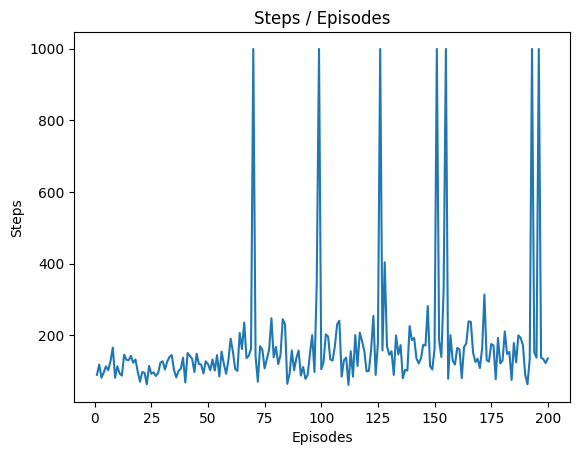

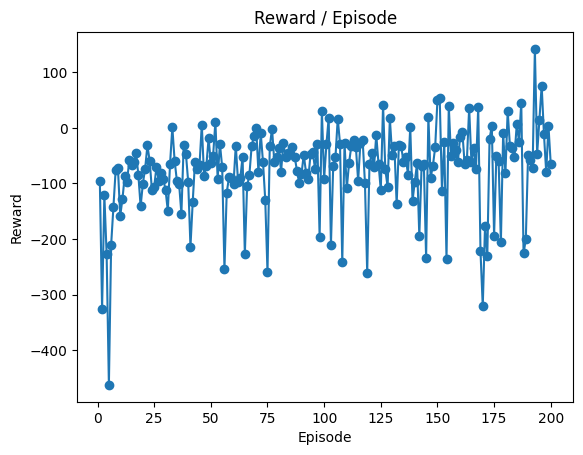

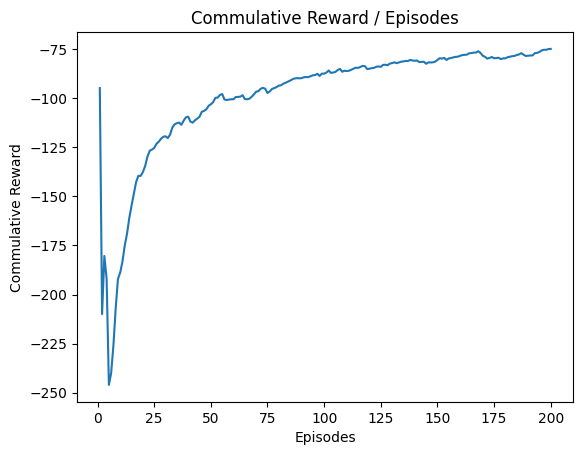

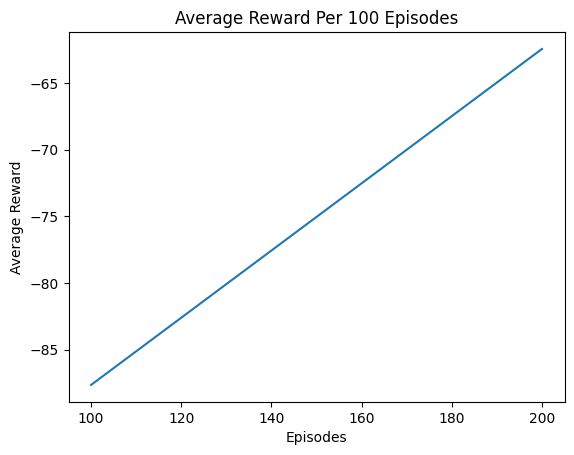

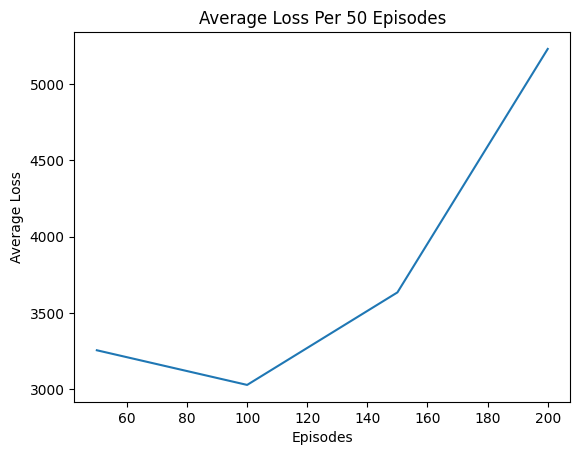

Moviepy - Building video /content/folder/video--episode-200.mp4.
Moviepy - Writing video /content/folder/video--episode-200.mp4



Moviepy - Done !
Moviepy - video ready /content/folder/video--episode-200.mp4


Moviepy - Building video /content/folder/video--episode-200.mp4.
Moviepy - Writing video /content/folder/video--episode-200.mp4



Moviepy - Done !
Moviepy - video ready /content/folder/video--episode-200.mp4
total episodes: 200
total time: 7.139786005020142
total steps to complete the episode: 302
reward for current state: -100
reward for this episode: -11.31794940306986


Moviepy - Building video /content/folder/video--episode-250.mp4.
Moviepy - Writing video /content/folder/video--episode-250.mp4



Moviepy - Done !
Moviepy - video ready /content/folder/video--episode-250.mp4


Moviepy - Building video /content/folder/video--episode-250.mp4.
Moviepy - Writing video /content/folder/video--episode-250.mp4



Moviepy - Done !
Moviepy - video ready /content/folder/video--episode-250.mp4
total episodes: 250
total time: 3.92484188079834
total steps to complete the episode: 197
reward for current state: -100
reward for this episode: 47.5527322397495




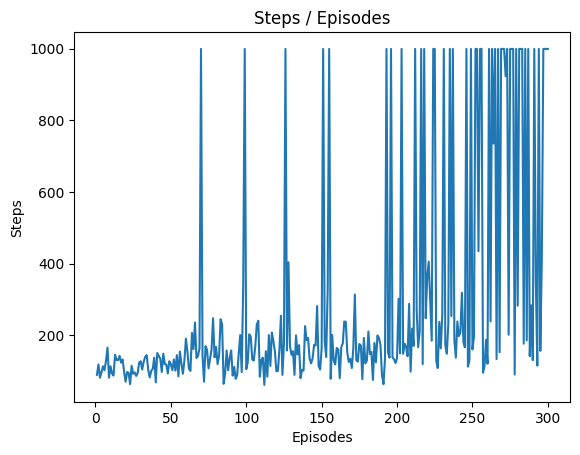

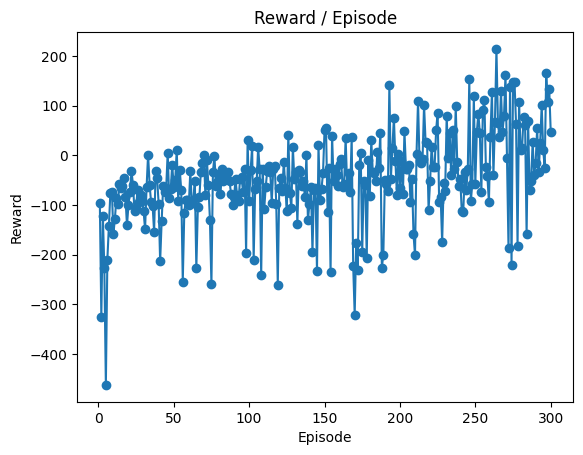

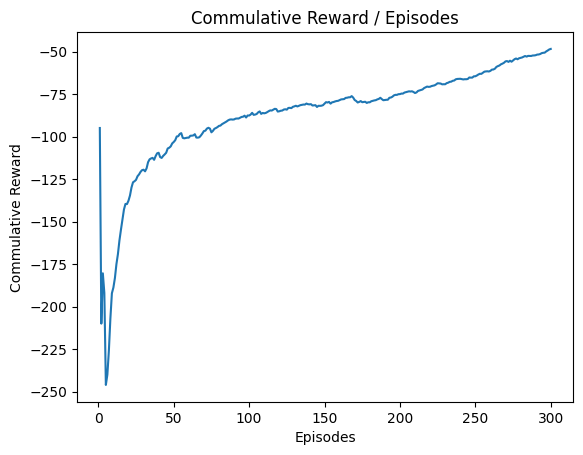

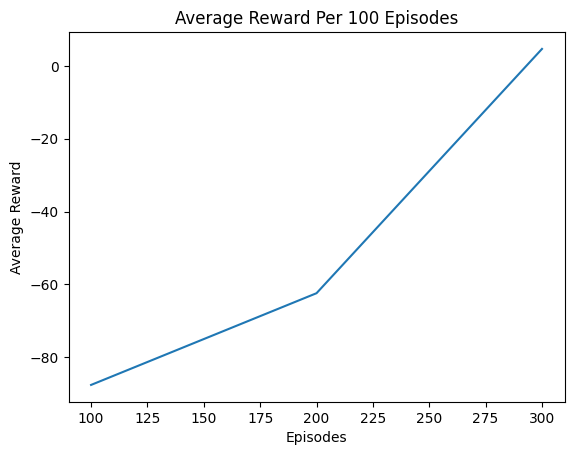

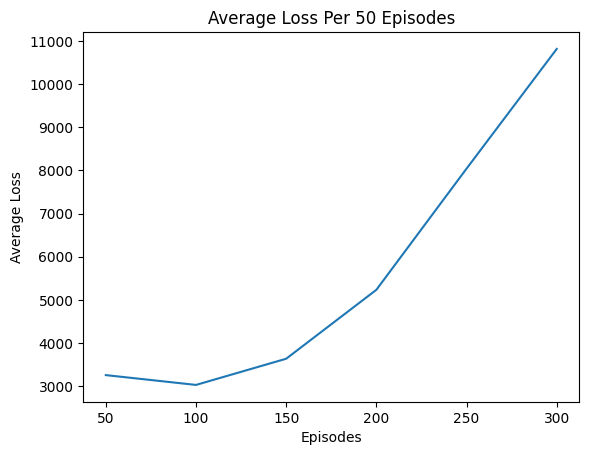

Moviepy - Building video /content/folder/video--episode-300.mp4.
Moviepy - Writing video /content/folder/video--episode-300.mp4



Moviepy - Done !
Moviepy - video ready /content/folder/video--episode-300.mp4


Moviepy - Building video /content/folder/video--episode-300.mp4.
Moviepy - Writing video /content/folder/video--episode-300.mp4



Moviepy - Done !
Moviepy - video ready /content/folder/video--episode-300.mp4
total episodes: 300
total time: 19.80139183998108
total steps to complete the episode: 999
reward for current state: -18.864702926829498
reward for this episode: 60.40504981108249


Moviepy - Building video /content/folder/video--episode-350.mp4.
Moviepy - Writing video /content/folder/video--episode-350.mp4



Moviepy - Done !
Moviepy - video ready /content/folder/video--episode-350.mp4


Moviepy - Building video /content/folder/video--episode-350.mp4.
Moviepy - Writing video /content/folder/video--episode-350.mp4



Moviepy - Done !
Moviepy - video ready /content/folder/video--episode-350.mp4
total episodes: 350
total time: 1.9773249626159668
total steps to complete the episode: 88
reward for current state: -100
reward for this episode: 21.612288782703487




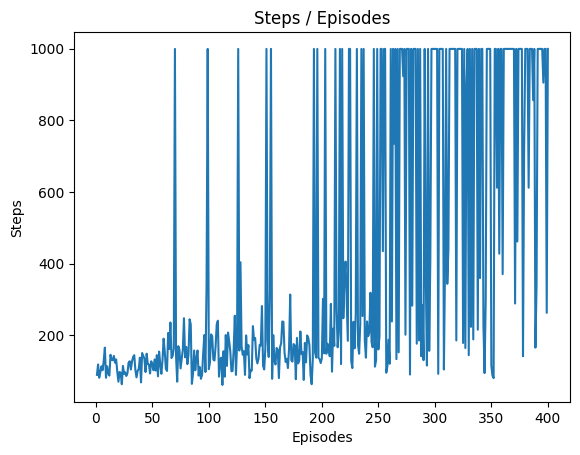

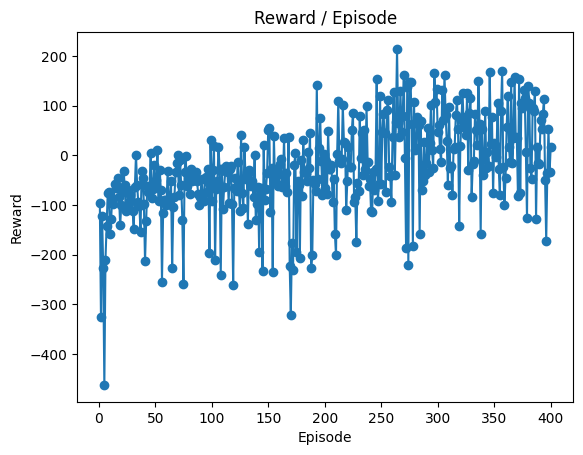

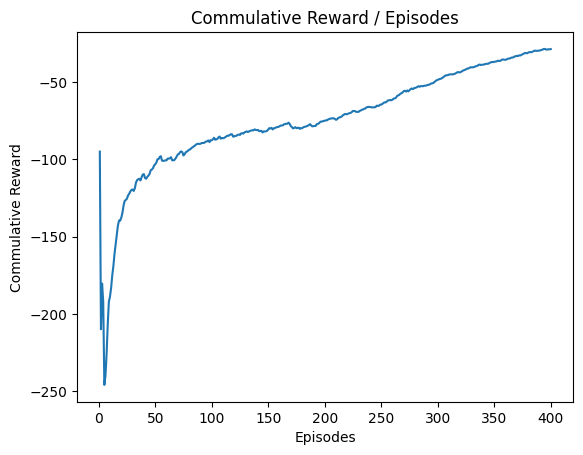

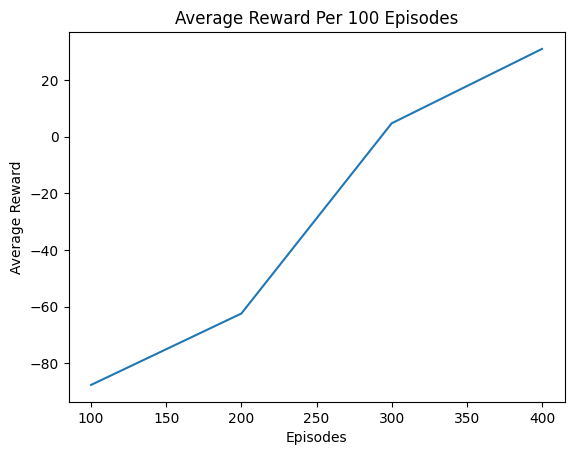

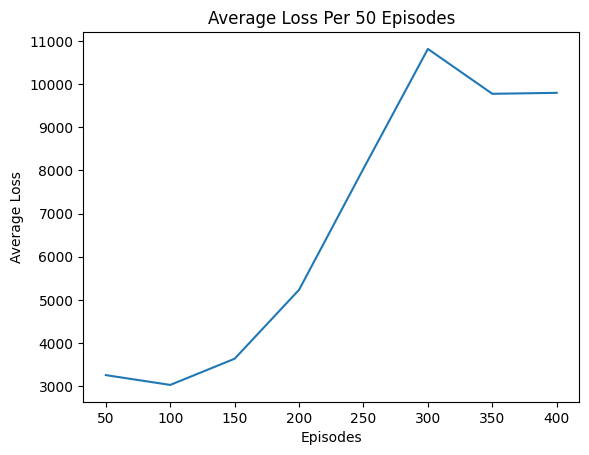

Moviepy - Building video /content/folder/video--episode-400.mp4.
Moviepy - Writing video /content/folder/video--episode-400.mp4



Moviepy - Done !
Moviepy - video ready /content/folder/video--episode-400.mp4


Moviepy - Building video /content/folder/video--episode-400.mp4.
Moviepy - Writing video /content/folder/video--episode-400.mp4



Moviepy - Done !
Moviepy - video ready /content/folder/video--episode-400.mp4
total episodes: 400
total time: 21.803740978240967
total steps to complete the episode: 999
reward for current state: 1.9564462759744579
reward for this episode: -27.806320448307602


Moviepy - Building video /content/folder/video--episode-450.mp4.
Moviepy - Writing video /content/folder/video--episode-450.mp4



Moviepy - Done !
Moviepy - video ready /content/folder/video--episode-450.mp4


In [ ]:
result = testbed(epi=1000, steps_taken=1000, epsilon=0.7, min_epsilon=0.01, epsilon_decay=0.001, batch_size=32, gamma=0.95, lr=0.001, fc_1=256, fc_2=128, fc_3=64)

In [ ]:
# Graphs visualization

episodes, steps_per_episode, episode_rewards, total_losses = result
plot_steps_per_episode(episodes, steps_per_episode)
plot_rewards_per_episode(episodes, episode_rewards)
plot_cumulative_rewards(episodes, episode_rewards)
plot_average_reward_per_hundred_episodes(episodes, episode_rewards)
plot_loss_function(episodes, total_losses)